#  자연어와 단어의 분산표현

## 어떻게 단어의 의미를 컴퓨터에게 이해시킬까?

1. 시소러스를 활용한기법
2. 통계 기반 기법
3. 추론 기반 기법(word2vec)

## 통계 기반 기법 

### 파이썬으로 말뭉치 전처리하기

In [2]:
text = 'You say goodbye and I say hello.'

In [3]:
text = text.lower()
text = text.replace('.',' .')
text

'you say goodbye and i say hello .'

In [4]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [5]:
word_to_id = {}
id_to_word = {}

for word in words :
    if word not in word_to_id :
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [6]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [7]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [8]:
id_to_word[1]

'say'

In [9]:
import numpy as np

In [10]:
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [11]:
def preprocess(text) :
    text = text.lower()
    text = text.replace('.',' .')
    text = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words :
        if word not in word_to_id :
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

# corpus -> 단어 ID목록, word_to_id -> 단어에서 단어 ID로 , id_to_word -> 단어 ID에서 단어로

### 동시발생 행렬

In [12]:
import sys
text
corpus, word_to_id, id_to_word = preprocess(text)

In [13]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [14]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [15]:
def create_co_matrix(corpus, vocab_size, window_size =1): # 윈도우 사이즈 -> 맥락크기
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus) :
        for i in range(1, window_size+1) :
            left_idx = idx-i
            right_idx = idx+i
            
            if left_idx >= 0 :
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] +=1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] +=1
    return co_matrix

### 벡터 간 유사도

In [16]:
def cos_similarity(x,y, eps = 1e-8) :
    nx = x / np.sqrt(np.sum(x**2) + eps) # x의 정규화
    ny = y / np.sqrt(np.sum(y**2) + eps) # y의 정규화
    return np.dot(nx, ny)

In [17]:
vocab_size = len(word_to_id)

In [18]:
C = create_co_matrix(corpus, vocab_size)

In [19]:
C0 = C[word_to_id['you']]
C1 = C[word_to_id['i']]
print(cos_similarity(C0,C1))

0.7071067758832467


### 유사 단어의 랭킹 표시

In [20]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어를 꺼낸다
    if query not in word_to_id :
        print("%s(을)를 찾을 수 없습니다." % query)
        return
    
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size) :
        similarity[i] = cos_similarity(word_matrix[i],query_vec)
    
    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort() : # argsort() -> 넘파이 원소를 오름차순으로 정렬 후 인덱스 반환, -1 곱하면 내림차순
        if id_to_word[i] == query:
            continue
        print('%s : %s' %(id_to_word[i], similarity[i].round(2)))
        count +=1
        if count >= top :
            return

In [21]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
goodbye : 0.71
i : 0.71
hello : 0.71
say : 0.0
and : 0.0


## 통계 기반 기법 개선하기

### 상호정보량

In [22]:
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [38]:
def ppmi(C, verbose = False, eps = 1e-8): # verbose = 진행상황 출력 여부를 결정
    M = np.zeros_like(C, dtype = np.float32)
    N = np.sum(C) # 말뭉치 단어의 수
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]) :
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j]*N / (S[j]*S[i])+eps)
            M[i,j] = max(0,pmi)
            
            if verbose :
                cnt +=1
                if cnt % (total//100) == 0 :
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [39]:
W = ppmi(C)
np.set_printoptions(precision=3)
print('동시발생행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [26]:
np.sum(C, axis=0)

array([1, 4, 2, 2, 2, 2, 1])

### 차원감소

In [40]:
U, S, V = np.linalg.svd(W)

In [41]:
np.linalg.svd(W)

(array([[ 3.409e-01, -1.110e-16, -4.441e-16, -1.205e-01,  0.000e+00,
         -9.323e-01, -1.086e-16],
        [ 0.000e+00, -5.976e-01,  1.802e-01,  0.000e+00, -7.812e-01,
          0.000e+00,  0.000e+00],
        [ 4.363e-01, -5.551e-17, -2.220e-16, -5.088e-01, -1.388e-17,
          2.253e-01, -7.071e-01],
        [ 1.620e-16, -4.978e-01,  6.804e-01, -5.249e-17,  5.378e-01,
         -1.285e-16,  8.576e-18],
        [ 4.363e-01, -3.229e-17, -1.654e-16, -5.088e-01, -1.345e-17,
          2.253e-01,  7.071e-01],
        [ 7.092e-01, -3.229e-17, -1.654e-16,  6.839e-01, -1.345e-17,
          1.710e-01,  7.688e-17],
        [-2.564e-16, -6.285e-01, -7.103e-01,  8.460e-17,  3.169e-01,
          2.492e-16, -1.104e-17]], dtype=float32),
 array([3.168e+00, 3.168e+00, 2.703e+00, 2.703e+00, 1.514e+00, 1.514e+00,
        2.555e-17], dtype=float32),
 array([[-0.000e+00,  5.976e-01,  2.257e-16,  4.978e-01,  1.701e-16,
         -2.739e-16,  6.285e-01],
        [-3.409e-01, -1.110e-16, -4.363e-01,  0.0

In [42]:
print(U[0,:2]) # 밀집벡터의 차원 감소, 2차원 벡터로 줄어듦

[ 3.409e-01 -1.110e-16]


In [45]:
import matplotlib.pyplot as plt

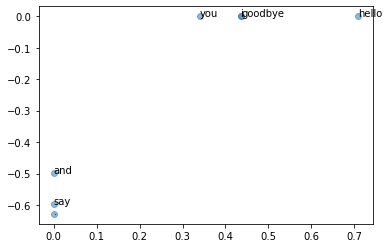

In [53]:
for word, word_id in word_to_id.items() :
    plt.annotate(word, (U[word_id,0], U[word_id,1])) # 2차원으로 표현

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [52]:
U[1,0], U[1,1], U[1,2]

(0.0, -0.5976364, 0.1802379)

### PTB 데이터셋

In [57]:
import ptb

In [59]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

Done


In [ ]:
# corpus : 

In [63]:
len(id_to_word)

10000

In [64]:
len(corpus)

929589

In [61]:
word_to_id

{'aer': 0,
 'banknote': 1,
 'berlitz': 2,
 'calloway': 3,
 'centrust': 4,
 'cluett': 5,
 'fromstein': 6,
 'gitano': 7,
 'guterman': 8,
 'hydro-quebec': 9,
 'ipo': 10,
 'kia': 11,
 'memotec': 12,
 'mlx': 13,
 'nahb': 14,
 'punts': 15,
 'rake': 16,
 'regatta': 17,
 'rubens': 18,
 'sim': 19,
 'snack-food': 20,
 'ssangyong': 21,
 'swapo': 22,
 'wachter': 23,
 '<eos>': 24,
 'pierre': 25,
 '<unk>': 26,
 'N': 27,
 'years': 28,
 'old': 29,
 'will': 30,
 'join': 31,
 'the': 32,
 'board': 33,
 'as': 34,
 'a': 35,
 'nonexecutive': 36,
 'director': 37,
 'nov.': 38,
 'mr.': 39,
 'is': 40,
 'chairman': 41,
 'of': 42,
 'n.v.': 43,
 'dutch': 44,
 'publishing': 45,
 'group': 46,
 'rudolph': 47,
 'and': 48,
 'former': 49,
 'consolidated': 50,
 'gold': 51,
 'fields': 52,
 'plc': 53,
 'was': 54,
 'named': 55,
 'this': 56,
 'british': 57,
 'industrial': 58,
 'conglomerate': 59,
 'form': 60,
 'asbestos': 61,
 'once': 62,
 'used': 63,
 'to': 64,
 'make': 65,
 'kent': 66,
 'cigarette': 67,
 'filters': 68,
 'h

### PTB 데이터셋 평가

In [65]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시 발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산')
W = ppmi(C, verbose=True)

동시 발생 수 계산...
PPMI 계산


<ipython-input-38-e3fe03ee76bb>:10: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i,j]*N / (S[j]*S[i])+eps)
<ipython-input-38-e3fe03ee76bb>:10: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i,j]*N / (S[j]*S[i])+eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료


In [69]:
len(W[1])

10000

In [72]:
print('SVD 계산')
try :
    # 빠른 버전
    from sklearn.utils.extmath import randomized_svd
    U,S,V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError :
    # 느린 버전
    U, S, V = np.linalg.svd(W)

word_vecs = U[:,:wordvec_size]
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

SVD 계산

[query]you
i : 0.68
we : 0.65
do : 0.6
anybody : 0.57
else : 0.52

[query]year
month : 0.64
quarter : 0.62
february : 0.62
june : 0.61
months : 0.61

[query]car
luxury : 0.57
auto : 0.54
cars : 0.54
vehicle : 0.49
routes : 0.47

[query]toyota
motor : 0.71
nissan : 0.67
motors : 0.65
lexus : 0.6
mazda : 0.59
